# Generating and visualizing communities

This notebook demonstrates the process of community detection and provides a comprehensive suite of methods for visualizing the results. Community detection is a fundamental task in network science focused on identifying groups of nodes, known as communities or clusters, that are more densely connected to each other than to the rest of the network.

Using the igraph library, we will apply a powerful multilevel algorithm to a sample network. We will then explore four distinct visualization techniques to gain insight into the identified community structure:

* Igraph Visualizations: Basic, static 2D visualizations for a quick overview of the network layout.

* Matplotlib Visualizations: Static 2D plots using the versatile matplotlib library, useful for creating high-quality, customizable figures for reports or publications.

* Interactive 3D Plot (create_plotly_3d_viz): An interactive three-dimensional visualization where each community is placed on its own horizontal layer. This allows for an intuitive exploration of the spatial separation and cohesion of the clusters.

* Clustered Adjacency Matrix Visualization (clustered_adj_matrix_viz): This method reorders the network's adjacency matrix to display communities as dense blocks along the diagonal, providing a clear visual representation of internal and external connections.

Through this walkthrough, you will learn how to detect communities and interpret their structure using a variety of compelling and informative visualizations.

In [1]:
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors 
from scipy.spatial import ConvexHull
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.patches import Patch 
import os
import random
import plotly.graph_objects as go
import plotly.offline as py
ig.config["plotting.backend"] = "matplotlib"

*Note:* `igraph` has two stable plotting backends at the moment: Cairo and Matplotlib. It also has experimental support for plotly. The Cairo backend is dependent on the pycairo or cairocffi libraries that provide Python bindings to the popular Cairo library. In our case we want to use the matplotlib backend to avoid additional dependencies, so it is useful to fix the `plotting.backend` in the config in each notebook we want to use `igraph`'s plotting functions. 

First, we load the Zachary Karate Club graph, a well-known benchmark for community detection. We then ensure the graph is connected, focusing on its largest connected component if necessary.

In [2]:
g = ig.Graph.Famous("Zachary")

# Ensuring the graph is connected (can be useful for clustering)
if not g.is_connected():
    components = g.components()
    g = g.subgraph(components.giant())

Now, we will visualize the graph (without any clustering yet)

*Note:* Using a specific layout in an `igraph` plot is useful because it allows you to control how the graph's structure is visually represented, making it easier to understand and interpret your data. While a plot will work without an explicit layout (as `igraph` uses a default), this default choice may not be the most effective for every type of graph. A deliberate choice of layout can improve the clarity and insight gained from your visualization.

For example, a **Fruchterman-Reingold (FR) layout** is a type of force-directed algorithm that is excellent for revealing clusters and communities. However, since it begins with a random initial placement of nodes, the resulting plot may look slightly different each time you run it.

To ensure the layout is fixed and reproducible for consistent comparison of plots, you need to set a seed before generating the layout. This guarantees that the initial random node positions are always the same, which in turn produces the exact same final layout every time you plot the same graph.

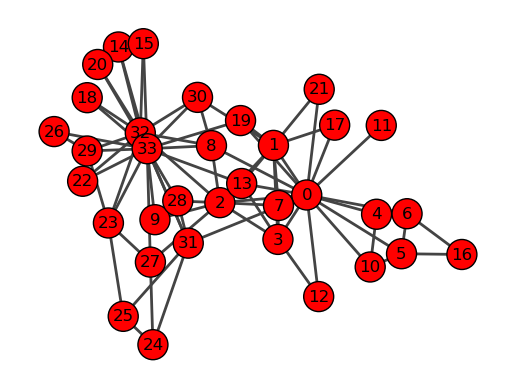

In [3]:
random.seed(888)
layout = g.layout("fr")
ig.plot(g, layout=layout, vertex_label=g.vs.indices);

## Generating communities
Let's continue with the clustering, using the Louvain algorithm first:

In [4]:
clusters = g.community_multilevel()

### Visualizing communities
Next, we can create a few visualizations using igraph and matplotlib.

The simplest way to plot communities using `igraph` is to just use the `plot` function on the detected communities:

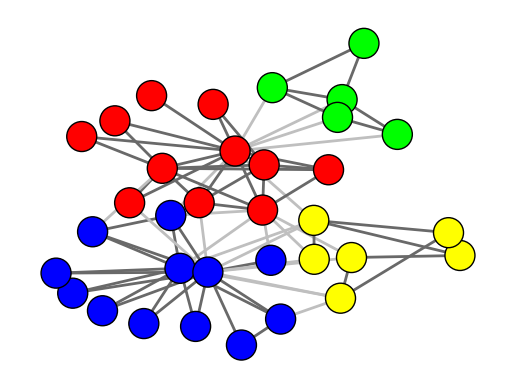

In [5]:
ig.plot(clusters);

We can apply the previously calculated layout and the the `mark_groups` parameter to true in order to separate even more the detected communities visually, optionally set the `vertex_label` parameter for the sake of consistency:

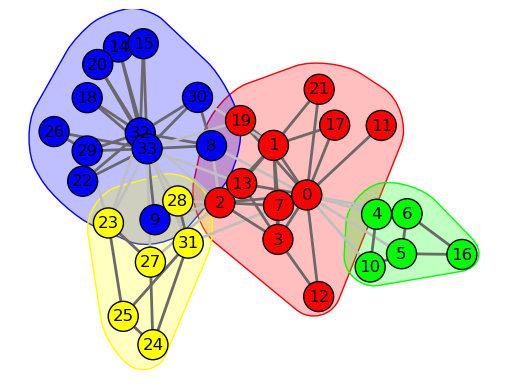

In [6]:
ig.plot(clusters, layout=layout, mark_groups=True, vertex_label=g.vs.indices);

Optionally, we can use different colormaps to visualize detected communities and pass them as the `vertex_color` parameter and even change the size of the nodes by setting the `vertex_size`, as shown in the example below:

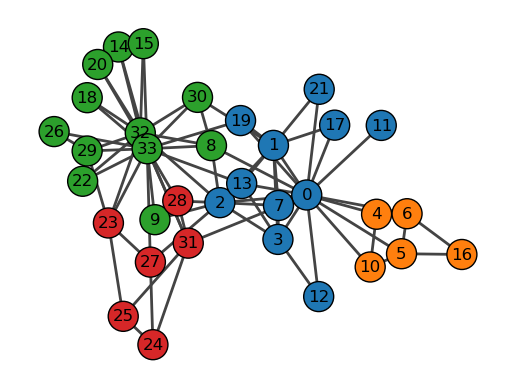

In [7]:
def simple_ig_viz(graph, communities, layout=None):
    colors_map = plt.colormaps["tab10"]
    colors = [colors_map(cluster) for cluster in communities.membership]

    if layout is None:
        layout = graph.layout("fr")  # Fruchterman-Reingold
    return ig.plot(graph, layout=layout, vertex_size=30, vertex_color=colors, vertex_label=graph.vs.indices)

    
simple_ig_viz(g, clusters, layout=layout);

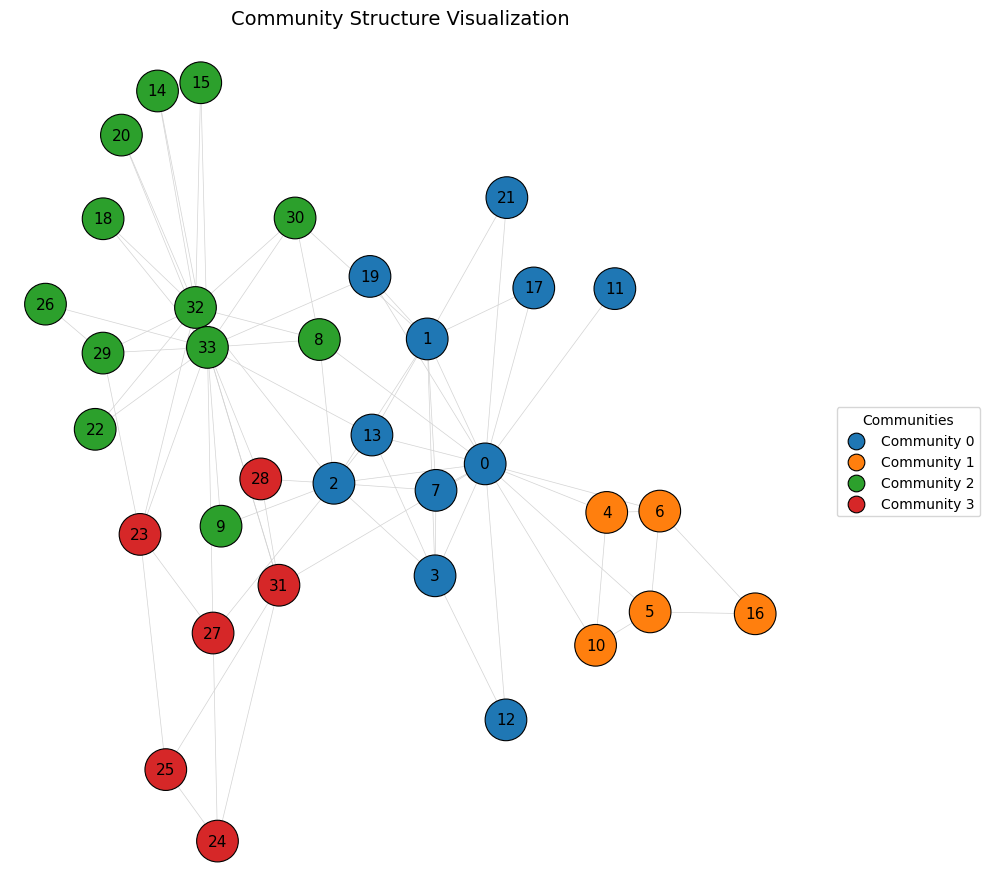

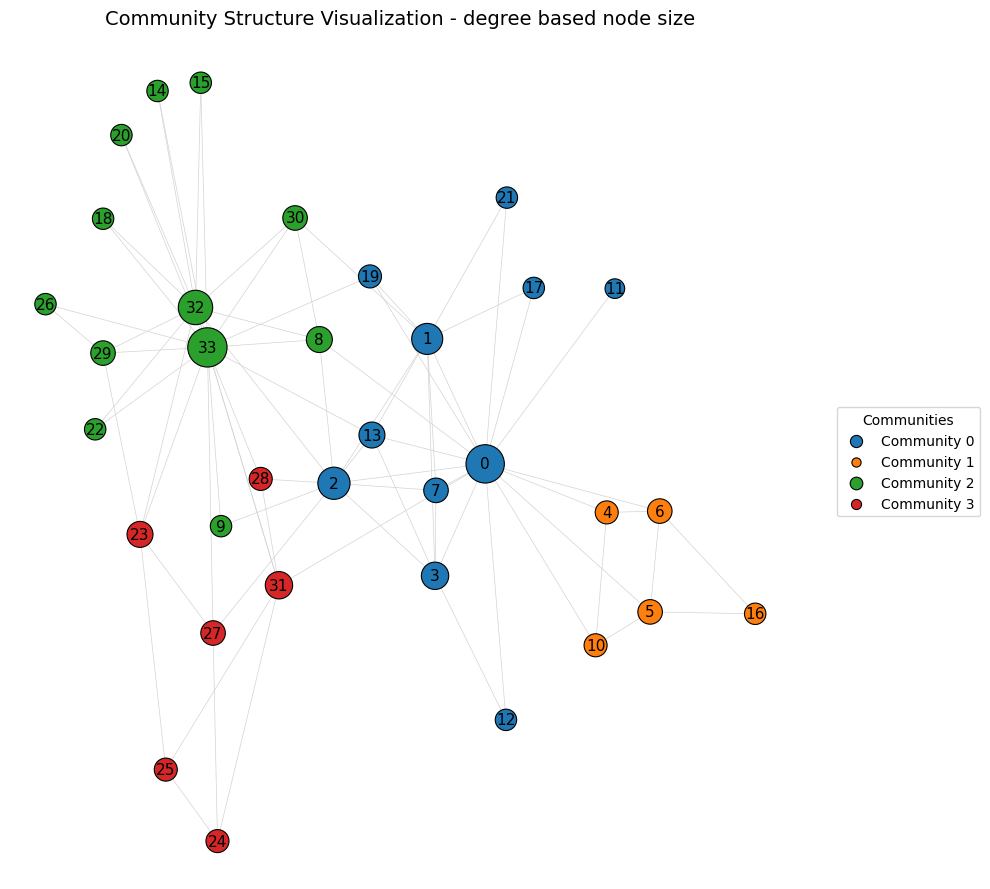

In [8]:
def simple_matplotlib_viz(graph, communities, layout=None, degree_based_node_sizes=False, title="Community Structure Visualization"):
    if layout is None:
        layout = graph.layout("fr")
    
    coords = np.array(layout.coords)
    membership = communities.membership
    unique_communities = sorted(list(set(membership)))
    
    fig, ax = plt.subplots(figsize=(10, 9))
    ax.set_title(title, fontsize=14, pad=15)
    ax.set_axis_off()

    if degree_based_node_sizes:
        degrees = graph.degree()
        min_degree = min(degrees) if degrees else 0
        max_degree = max(degrees) if degrees else 1
        if max_degree == min_degree:
            node_sizes = [900 for _ in degrees]
        else:
            node_sizes = [200 + 600 * ((d - min_degree) / (max_degree - min_degree)) for d in degrees]
    else:
        node_sizes = [900 for _ in range(graph.vcount())]

    edges = np.array(graph.get_edgelist())
    edge_coords = coords[edges]
    ax.plot(edge_coords[:, :, 0].T, edge_coords[:, :, 1].T,
            color="lightgray", linewidth=0.5, zorder=1)

    # Choose a colormap; 'tab10' for up to 10 communities, 'viridis' for more
    cmap = plt.get_cmap('tab10' if len(unique_communities) <= 10 else 'viridis')

    for community_id in unique_communities:
        community_nodes_idx = [i for i, c in enumerate(membership) if c == community_id]
        
        # Plot all nodes in this community at once
        ax.scatter(coords[community_nodes_idx, 0], coords[community_nodes_idx, 1],
                   s=np.array(node_sizes)[community_nodes_idx],
                   color=cmap(community_id),
                   edgecolors='black',
                   linewidths=0.8,
                   zorder=2,
                   label=f'Community {community_id}')

    for idx, (x, y) in enumerate(coords):
        ax.text(x, y, str(idx),
                fontsize=11,
                color='black',
                ha='center',
                va='center',
                zorder=3)

    ax.legend(title="Communities",
              loc='center left',
              bbox_to_anchor=(1.05, 0.5),
              fontsize=10,
              markerscale=0.4)

    plt.tight_layout()
    plt.show()

    
simple_matplotlib_viz(g, clusters, layout=layout)
simple_matplotlib_viz(g, clusters, layout=layout, degree_based_node_sizes=True, title="Community Structure Visualization - degree based node size")

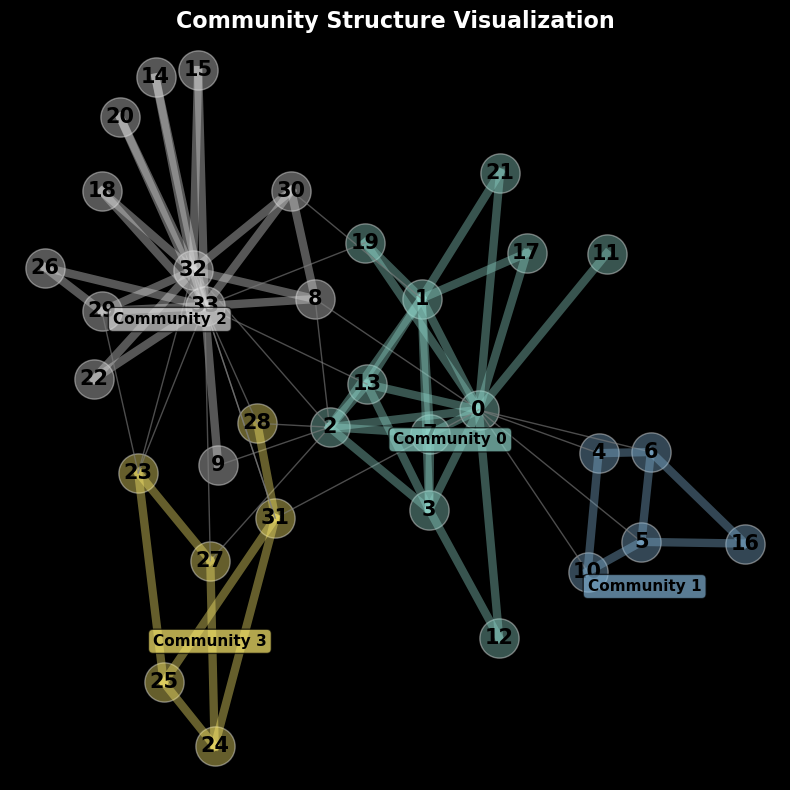

In [9]:
def community_neon_viz(graph, communities, layout=None, title="Community Structure Visualization"):
    figsize=(8, 8)
    if layout is None:
        layout = graph.layout("fr") 
    coords = np.array(layout.coords)
    x_coords = coords[:, 0]
    y_coords = coords[:, 1]
    
    n_communities = len(communities)
    colors = plt.cm.Set3(np.linspace(0, 1, n_communities))
    
    fig, ax = plt.subplots(figsize=figsize, facecolor='black')
    ax.set_facecolor('black')
    
    for edge in graph.es:
        source_idx = edge.source
        target_idx = edge.target
        source_community = communities.membership[source_idx]
        target_community = communities.membership[target_idx]
        
        x_line = [x_coords[source_idx], x_coords[target_idx]]
        y_line = [y_coords[source_idx], y_coords[target_idx]]
        
        if source_community == target_community:
            edge_color = colors[source_community]
            width = 6
            alpha = 0.4
            ax.plot(x_line, y_line, color=edge_color, linewidth=width, alpha=alpha)
        else:
            ax.plot(x_line, y_line, color='gray', linewidth=1, alpha=0.6)
    
    for comm_idx, community in enumerate(communities):
        community_nodes = list(community)
        community_x = [x_coords[node] for node in community_nodes]
        community_y = [y_coords[node] for node in community_nodes]
        
        color = colors[comm_idx]
        
        size = 800
        alpha = 0.4
        ax.scatter(community_x, community_y, s=size, c=[color], 
                  alpha=alpha, edgecolors='white', linewidth=1)
    
    for i in range(graph.vcount()):
        ax.text(x_coords[i], y_coords[i], str(i), 
               ha='center', va='center', fontsize=15, 
               color='black', fontweight='bold', zorder=3)
    
    for comm_idx, community in enumerate(communities):
        community_nodes = list(community)
        if community_nodes: 
            center_x = np.mean([x_coords[node] for node in community_nodes])
            center_y = np.mean([y_coords[node] for node in community_nodes])
            
            ax.text(center_x, center_y - 0.6, f'Community {comm_idx}', 
                   ha='center', va='center', fontsize=11, 
                   color='black', fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[comm_idx], alpha=0.7))
    
    ax.set_title(title, color='white', fontsize=16, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()


community_neon_viz(g, clusters, layout=layout)

In [10]:
# NOTE: we need this line in order to display plot in the notebook
py.init_notebook_mode(connected=True)
def create_plotly_3d_viz(graph, communities, layout=None, title="Community Structure Visualization"):
    if layout is None:
        layout = graph.layout("fr")
    coords_2d = np.array(layout.coords)
    
    n_communities = len(communities)
    z_levels = np.linspace(-1, 2, n_communities)
    
    x_coords = coords_2d[:, 0]
    y_coords = coords_2d[:, 1]
    z_coords = np.array([z_levels[communities.membership[i]] for i in range(graph.vcount())])
    
    edge_x, edge_y, edge_z = [], [], []
    for edge in graph.es:
        source_idx, target_idx = edge.source, edge.target
        edge_x.extend([x_coords[source_idx], x_coords[target_idx], None])
        edge_y.extend([y_coords[source_idx], y_coords[target_idx], None])
        edge_z.extend([z_coords[source_idx], z_coords[target_idx], None])
        
    edge_trace = go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        mode='lines',
        line=dict(color='gray', width=2),
        hoverinfo='none',
        opacity=0.6,
        showlegend=False
    )
    
    node_labels = [str(v.index) for v in graph.vs]
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(set(communities.membership))))
    plotly_colorscale = [[i / (len(colors) - 1), f'rgb({int(c[0]*255)},{int(c[1]*255)},{int(c[2]*255)})'] for i, c in enumerate(colors)]

    node_trace = go.Scatter3d(
        x=x_coords, y=y_coords, z=z_coords,
        mode='markers+text',
        name='nodes',
        marker=dict(
            symbol='circle',
            size=10,
            color=communities.membership,
            colorscale=plotly_colorscale,
            line=dict(color='black', width=1)
        ),
        text=node_labels,
        textposition='middle center',
        hoverinfo='text',
        hovertext=[f'Node: {i}<br>Community: {communities.membership[i]}' for i in range(graph.vcount())]
    )

    z_min, z_max = np.min(z_coords), np.max(z_coords)
    z_range = [z_min - 0.8, z_max + 0.8]
    y_min, y_max = np.min(y_coords), np.max(y_coords)
    y_range = [y_min - 0.8, y_max + 0.8]
    
    fig = go.Figure(
        data=[edge_trace, node_trace],
        layout=go.Layout(
            title=title,
            title_x=0.5,
            scene=dict(
                xaxis=dict(
                    showbackground=True, showticklabels=True, title='X-Axis',
                    backgroundcolor='rgb(240, 240, 240)',
                    gridcolor='rgb(180, 180, 180)',
                    showgrid=True
                ),
                yaxis=dict(
                    showbackground=True, showticklabels=True, title='Y-Axis',
                    backgroundcolor='rgb(240, 240, 240)',
                    gridcolor='rgb(180, 180, 180)',
                    showgrid=True,
                    range=y_range
                ),
                zaxis=dict(
                    showbackground=True, showticklabels=True, title='Community Layer',
                    backgroundcolor='rgb(240, 240, 240)',
                    gridcolor='rgb(180, 180, 180)',
                    showgrid=True,
                    range=z_range
                ),
                aspectmode='data'
            ),
            margin=dict(l=0, r=0, b=0, t=30),
            showlegend=False
        )
    )
    
    py.iplot(fig)
    

create_plotly_3d_viz(g, clusters, layout=layout)

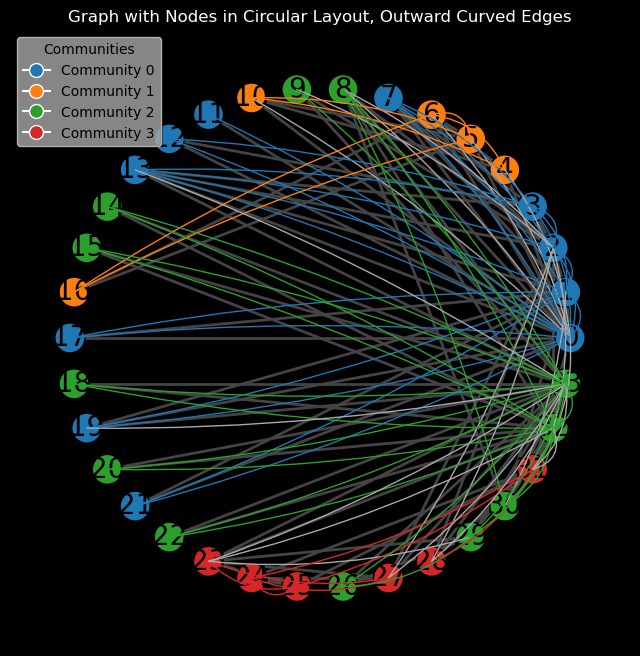

In [11]:
def circular_community_viz(graph, communities, title="Community Structure Visualization"):
    layout = graph.layout("circle")

    node_positions = np.array(layout.coords)

    num_communities = len(communities)
    colors_map = plt.colormaps['tab10']

    vertex_colors = [colors_map(communities.membership[i]) for i in range(graph.vcount())]

    custom_edge_paths = []
    manual_edge_colors = []
    manual_edge_widths = []

    layout_center = np.mean(node_positions, axis=0)

    outward_force = 0.1

    for edge in graph.es:
        source_node_id = edge.source
        target_node_id = edge.target

        p1 = node_positions[source_node_id]
        p2 = node_positions[target_node_id]

        source_community = communities.membership[source_node_id]
        target_community = communities.membership[target_node_id]

        # Determine edge color
        if source_community == target_community:
            rgba_color = colors_map(source_community)
            hex_color = '#%02x%02x%02x' % (int(rgba_color[0]*255), int(rgba_color[1]*255), int(rgba_color[2]*255))
        else:
            hex_color = "darkgrey"

        manual_edge_colors.append(hex_color)
        manual_edge_widths.append(1)

        mid_point = (p1 + p2) / 2

        vec_to_mid = mid_point - layout_center

        if np.linalg.norm(vec_to_mid) > 1e-6:
            offset_direction = vec_to_mid / np.linalg.norm(vec_to_mid)
        else:
            offset_direction = np.array([0, 1])
            
        control_point = mid_point + offset_direction * outward_force

        codes = [Path.MOVETO, Path.CURVE3, Path.LINETO]
        vertices = [p1, control_point, p2]
        path = Path(vertices, codes)
        custom_edge_paths.append(path)

    fig, ax = plt.subplots(figsize=(8, 8))

    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    ig.plot(
        g,
        target=ax,
        layout=layout,
        vertex_color=vertex_colors,
        vertex_size=30,
        vertex_label=[str(i) for i in range(g.vcount())],
        vertex_label_size=20,
        vertex_label_color="black",
        bbox=(400, 400),
        margin=20,
    )

    # Manually draw the custom curved edges
    for i, path in enumerate(custom_edge_paths):
        patch = PathPatch(path,
                          facecolor='none',
                          edgecolor=manual_edge_colors[i],
                          lw=manual_edge_widths[i],
                          capstyle='round',
                          zorder=1) # Ensure edges are above the background but below nodes
        ax.add_patch(patch)

    legend_handles = []
    for i in range(num_communities):
        handle = plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor=colors_map(i), markersize=10,
                            label=f'Community {i}')
        legend_handles.append(handle)

    ax.legend(handles=legend_handles, title="Communities", loc='best', labelcolor='black', title_fontsize='medium', facecolor='darkgrey')

    ax.set_title("Graph with Nodes in Circular Layout, Outward Curved Edges", color='white')

    plt.show()
    
    
circular_community_viz(g, clusters)

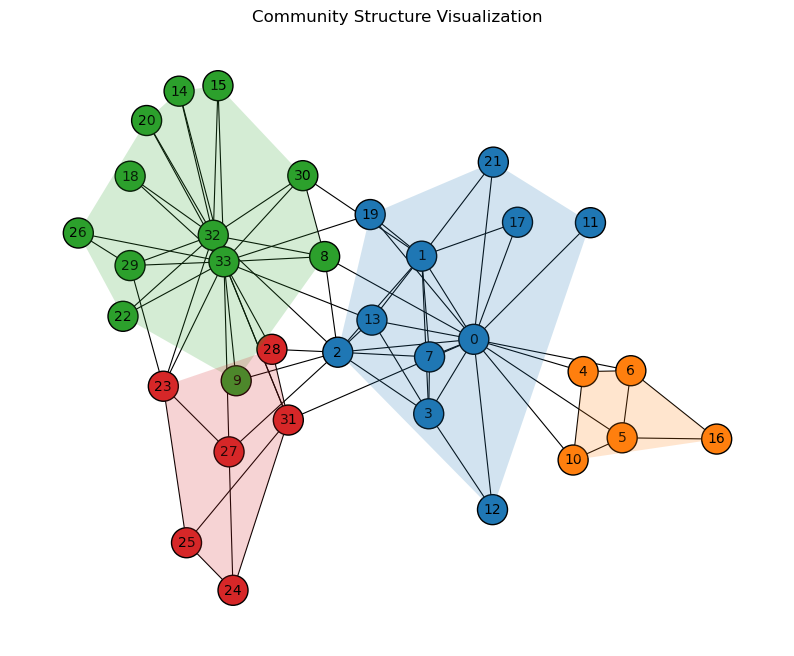

In [12]:
def communities_w_shading_viz(graph, communities, layout=None, title="Community Structure Visualization"):
    num_communities = len(communities)
    node_colors_map = plt.colormaps['tab10']
    vertex_colors = [node_colors_map(communities.membership[i] % node_colors_map.N) for i in range(graph.vcount())]

    if layout is None:
        layout = graph.layout("fr") # Fruchterman-Reingold layout for spatial separation of communities

    edge_colors = ["black"] * graph.ecount()
    edge_width = 0.8

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_facecolor('white') # Explicitly set background to white
    ax.set_title(title)

    ig.plot(
        graph,
        target=ax,
        layout=layout,
        vertex_color=vertex_colors, # Use the computed vertex_colors list
        vertex_size=30, # Adjust size as needed
        vertex_label=[str(i) for i in range(graph.vcount())], # Use graph.vcount() here
        vertex_label_size=10, # Adjusted for better visibility in plots
        vertex_label_color="black",
        edge_color=edge_colors,
        edge_width=edge_width,
        edge_curved=False,
        margin=50
    )

    for i in range(num_communities):
        community_nodes_indices = [v.index for v in graph.vs if communities.membership[v.index] == i]

        if len(community_nodes_indices) > 2: # Need at least 3 points for a meaningful convex hull
            community_coords = np.array([layout[idx] for idx in community_nodes_indices])

            try: # Use a try-except block for ConvexHull, as it can fail with collinear points
                hull = ConvexHull(community_coords)
                hull_points = community_coords[hull.vertices]

                patch = plt.Polygon(hull_points,
                                    facecolor=node_colors_map(i % node_colors_map.N), # Use the colormap directly
                                    alpha=0.2,
                                    edgecolor='none',
                                    zorder=0)
                ax.add_patch(patch)
            except Exception as e:
                # Handle cases where ConvexHull might fail (e.g., all points collinear)
                # For small communities (2 or 1 node), this block will be skipped due to len(community_nodes_indices) > 2 check
                print(f"Warning: Could not draw convex hull for community {i}. Error: {e}")
                # Fallback for very small or problematic communities:
                if len(community_coords) == 1:
                    ax.add_patch(plt.Circle(community_coords[0], radius=0.08, color=node_colors_map(i % node_colors_map.N), alpha=0.2, zorder=0))
                elif len(community_coords) == 2:
                    min_x, min_y = np.min(community_coords, axis=0)
                    max_x, max_y = np.max(community_coords, axis=0)
                    center_x = (min_x + max_x) / 2
                    center_y = (min_y + max_y) / 2
                    width = max_x - min_x + 0.1
                    height = max_y - min_y + 0.1
                    ax.add_patch(plt.Rectangle((min_x - 0.05, min_y - 0.05), width, height,
                                                color=node_colors_map(i % node_colors_map.N), alpha=0.2, zorder=0))
        elif len(community_nodes_indices) == 1:
            community_coords = np.array([layout[idx] for idx in community_nodes_indices])
            ax.add_patch(plt.Circle(community_coords[0], radius=0.08, color=node_colors_map(i % node_colors_map.N), alpha=0.2, zorder=0))
        elif len(community_nodes_indices) == 2:
            community_coords = np.array([layout[idx] for idx in community_nodes_indices])
            min_x, min_y = np.min(community_coords, axis=0)
            max_x, max_y = np.max(community_coords, axis=0)
            width = max_x - min_x + 0.1
            height = max_y - min_y + 0.1
            ax.add_patch(plt.Rectangle((min_x - 0.05, min_y - 0.05), width, height,
                                        color=node_colors_map(i % node_colors_map.N), alpha=0.2, zorder=0))


communities_w_shading_viz(g, clusters, layout=layout)

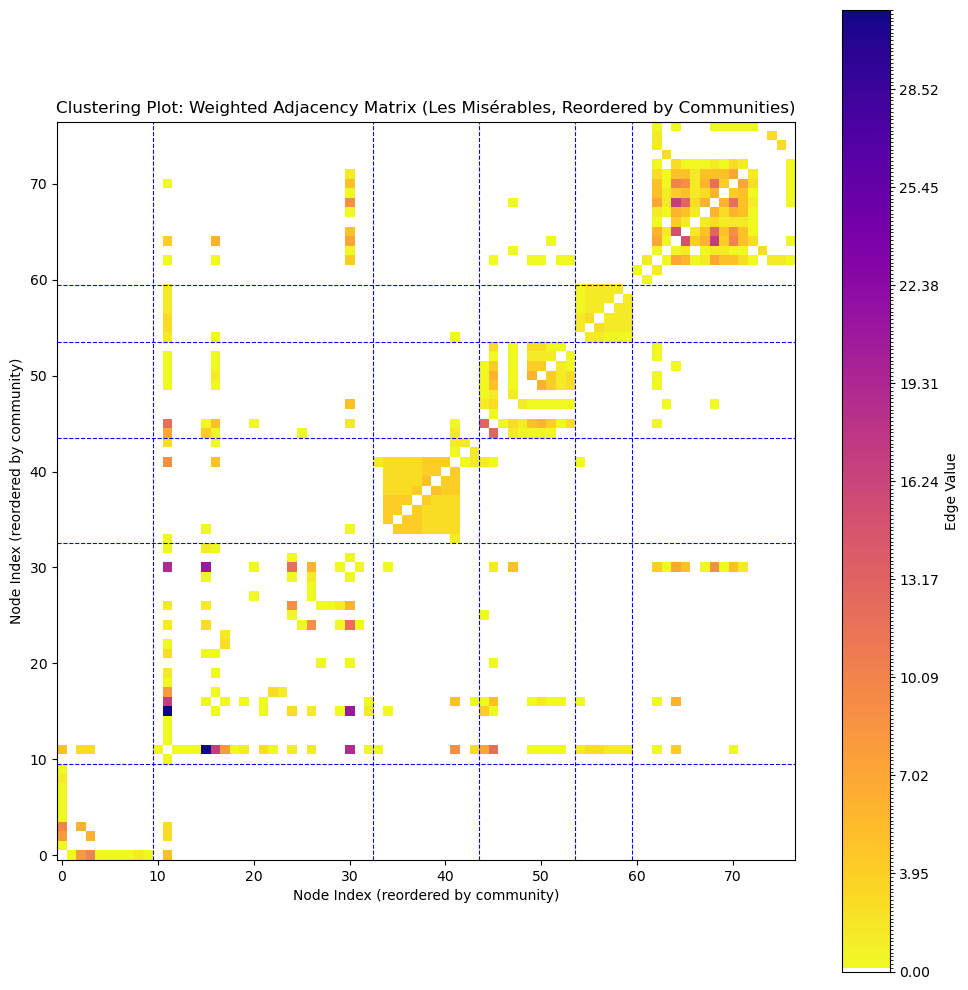

In [13]:
# NOTE: Usually useful for weighted networks
def clustered_adj_matrix_viz(graph, communities, weight_attribute_name="weight", title="Community Structure Visualization"):
    num_nodes = graph.vcount()
    
    # Get the membership of each node (which community it belongs to)
    node_memberships = communities.membership

    # --- Create a reordered adjacency matrix based on clustering ---
    adj_matrix = np.array(graph.get_adjacency(attribute=weight_attribute_name).data)

    # Create a permutation (reordering) of node indices based on community membership.
    sorted_node_indices = sorted(range(num_nodes), key=lambda i: (node_memberships[i], i))

    # Reorder the adjacency matrix using the sorted indices.
    reordered_adj_matrix = adj_matrix[sorted_node_indices, :][:, sorted_node_indices]

    # --- Create the clustering plot (adjacency matrix visualization) ---
    plt.figure(figsize=(10, 10))

    # Determine min and max weights from the graph for proper color scaling
    actual_weights = [edge[weight_attribute_name] for edge in graph.es if edge[weight_attribute_name] > 0] # Only consider positive weights for gradient
    if actual_weights:
        min_positive_weight = min(actual_weights)
        max_actual_weight = max(actual_weights)
    else:
        min_positive_weight = 0.1 # Small default if no positive weights
        max_actual_weight = 1 # Default if no edges

    # vmin for imshow should be 0 to map no connections to white
    # vmax for imshow should be the maximum actual weight
    # We set a small epsilon to ensure `vmin_gradient` is not zero if `min_positive_weight` is very small
    epsilon = 1e-9 
    vmin_gradient = min_positive_weight if min_positive_weight > 0 else epsilon


    # Number of colors in the gradient segment
    n_colors = 255
    cmap_gradient = plt.colormaps.get_cmap('plasma_r')

    # Create a new list of colors for the gradient part.
    # We map the gradient over the range from 0 to 1.
    colors = cmap_gradient(np.linspace(0, 1, n_colors))

    # Combine white for 0, and the gradient for positive values
    all_colors = np.vstack([[1, 1, 1, 1], colors]) # White for 0

    custom_cmap = mcolors.ListedColormap(all_colors, name='CustomPlasmaReversedWhite') 
    
    bounds = np.linspace(vmin_gradient, max_actual_weight, n_colors)
    norm = mcolors.BoundaryNorm(np.insert(bounds, 0, 0), custom_cmap.N)

    plt.imshow(reordered_adj_matrix, cmap=custom_cmap, origin='lower', norm=norm) # Use the custom norm

    plt.title(title)
    plt.xlabel('Node Index (reordered by community)')
    plt.ylabel('Node Index (reordered by community)')
    plt.colorbar(label=f'Edge {weight_attribute_name.capitalize()}') # Update colorbar label

    # Draw lines to delineate communities
    community_boundaries = [0]
    if sorted_node_indices: # Ensure there are nodes
        current_community = node_memberships[sorted_node_indices[0]]
        for i, node_idx in enumerate(sorted_node_indices):
            if node_memberships[node_idx] != current_community:
                community_boundaries.append(i)
                current_community = node_memberships[node_idx]
    community_boundaries.append(num_nodes) # Add the end boundary

    for boundary in community_boundaries:
        if boundary > 0 and boundary < num_nodes:
            plt.axhline(boundary - 0.5, color='blue', linestyle='--', linewidth=0.8)
            plt.axvline(boundary - 0.5, color='blue', linestyle='--', linewidth=0.8)

    plt.tight_layout()
    plt.show()


graph_file = "../networks/lesmis/lesmis.gml"
# igraph.Graph.Read_GML will automatically load edge attributes like 'value'
# if they are present in the GML file.
graph = ig.Graph.Read_GML(graph_file)
# Define the actual weight attribute name from the GML file
WEIGHT_ATTRIBUTE_NAME = "value"


clusters = graph.community_multilevel(weights=WEIGHT_ATTRIBUTE_NAME if WEIGHT_ATTRIBUTE_NAME in graph.edge_attributes() else None)
clustered_adj_matrix_viz(graph, clusters, weight_attribute_name=WEIGHT_ATTRIBUTE_NAME, title='Clustering Plot: Weighted Adjacency Matrix (Les Misérables, Reordered by Communities)')
